In [4]:
# !pip install uncertainty-toolbox

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct
from scipy.stats import spearmanr

## Loading information

All the information is saved in `../Output/Uncertainty` folder. So, we just load it to the `info` dictionary:

In [6]:
def get_info(filename):
    df = pd.read_json(filename)
    true_logK = df["true_logK"].to_numpy()
    pred_logK = df["pred_logK"].to_numpy()
    pred_logK_std = df["pred_logK_std"].to_numpy()
    return true_logK, pred_logK, pred_logK_std

In [7]:
info = {
    name: {
        phase: get_info(f"../Output/Uncertainty/{name}/{phase}.json")
        for phase in ("train", "valid", "test") if os.path.exists(f"../Output/Uncertainty/{name}/{phase}.json")
    } for name in os.listdir("../Output/Uncertainty")
}

## Miscalibration area

We visualize some plots to and calculate miscalibration area

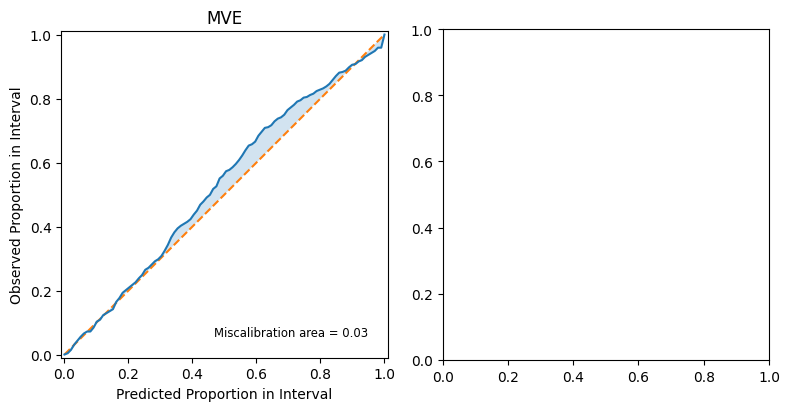

In [9]:
size = 4
n_rows = 2
n_cols = len(info) // n_rows + int(len(info) % n_rows != 0)

fig, axs = plt.subplots(n_cols, n_rows, figsize=(n_rows * size, n_cols * size))
axs = axs.reshape(-1)

for i, name in enumerate(["MVE"]):
    true_logK, pred_logK, pred_logK_std = info[name]["test"]
    
    axs[i] = uct.plot_calibration(pred_logK, pred_logK_std, true_logK, ax=axs[i])
    axs[i].set_title(name)

plt.tight_layout()

## Metrics

In [183]:
metrics = {}

for i, name in enumerate(["knn_latent", "ensemble", "MVE", "MVE_AcTest"]):
    true_logK, pred_logK, pred_logK_std = info[name]["test"]
    
    m = uct.metrics.get_all_metrics(pred_logK, pred_logK_std, true_logK, verbose=False)
    metrics[name] = {
        "NLL": m["scoring_rule"]["nll"],
        "Miscalibration area": m["avg_calibration"]["miscal_area"],
        "Spearman’s Rank": spearmanr(abs(pred_logK - true_logK), pred_logK_std)[0],
    }

In [184]:
pd.DataFrame(metrics.values(), index=metrics.keys())

,NLL,Miscalibration area,Spearman’s Rank
knn_latent,13.458054,0.109093,0.379042
ensemble,4.141071,0.281750,0.539162
MVE,1.368401,0.031258,0.700290
MVE_AcTest,2.356139,0.042683,0.613799


## Visualizations

In [17]:
def visualize(names=["MVE", "MVE_AcTest"], size=4, n_rows=3, n_cols=None):
    n_rows = min(n_rows, len(names))
    n_cols = len(names) // n_rows + int(len(names) % n_rows != 0)

    fig, axs = plt.subplots(n_cols, n_rows, figsize=(n_rows * size, n_cols * size))
    if len(names) == 1: axs = np.array([axs])
    axs = axs.reshape(-1)

    for i, name in enumerate(names):
        true_logK, pred_logK, pred_logK_std = info[name]["test"]
        error = pred_logK - true_logK

        in_1_std_mask = np.absolute(error) < pred_logK_std
        in_2_std_mask = (np.absolute(error) > pred_logK_std) & (np.absolute(error) < 2 * pred_logK_std)
        out_2_std_mask = np.absolute(error) > 2 * pred_logK_std

        x_max = max(pred_logK_std) * 1.1
        x = np.linspace(0, x_max, 200)
        axs[i].fill_between(x, -x, x, color="#AFDBBC")
        axs[i].fill_between(x, x, 2*x, color="#FAF9D4")
        axs[i].fill_between(x, -2*x, -x, color="#FAF9D4")
        axs[i].plot(x, [0]*len(x), color="black")
        axs[i].plot(pred_logK_std[in_1_std_mask], error[in_1_std_mask], ".", ms=3, color="green")
        axs[i].plot(pred_logK_std[in_2_std_mask], error[in_2_std_mask], ".", ms=3, color="#FFA812")
        axs[i].plot(pred_logK_std[out_2_std_mask], error[out_2_std_mask], ".", ms=3, color="red")

        in_1_std = sum(in_1_std_mask)
        in_2_std = sum(in_2_std_mask)
        out_2_std = sum(out_2_std_mask)

        axs[i].text(x_max*0.86, x_max*0.3, "%i%%" % (in_1_std / (in_1_std + in_2_std + out_2_std) * 100), color="green", weight=500)
        axs[i].text(x_max*0.86, x_max*1.3, "%i%%" % ((in_1_std + in_2_std) / (in_1_std + in_2_std + out_2_std) * 100), color="#ED760E", weight=500)
        axs[i].text(x_max*0.86, x_max*2.1, "%i%%" % (out_2_std / (in_1_std + in_2_std + out_2_std) * 100), color="red", weight=500)

        axs[i].set_title(name)
        axs[i].set_xlabel("estimated standard deviation")
        axs[i].set_ylabel("model error")
        axs[i].set_xlim(0, x_max)
        axs[i].set_ylim(-2.5 * x_max, 2.5 * x_max)
    plt.tight_layout()

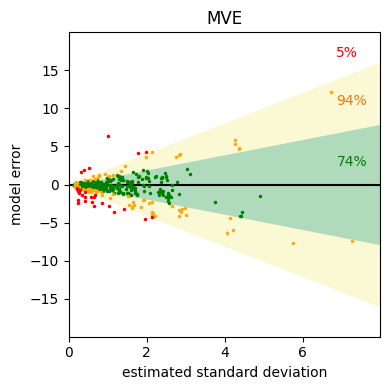

In [18]:
visualize(names=["MVE"])

In [51]:
def get_data(names, n_points=40):
    true_logK, pred_logK, pred_logK_std = info[name]["test"]
    error = pred_logK - true_logK

    limits = np.linspace(min(pred_logK_std), max(pred_logK_std), n_points)

    inside_mae = []
    outside_mae = []
    inside_percentage = []
    outside_percentage = []

    for limit in limits:

        mask = pred_logK_std <= limit

        inside_mae += [np.absolute(error[mask]).mean()]
        outside_mae += [np.absolute(error[~mask]).mean()]

        inside_percentage += [sum(mask) / len(mask)]
        outside_percentage += [sum(~mask) / len(mask)]
        
    return limits, inside_mae, outside_mae, inside_percentage, outside_percentage

def vis_cutoff_fraction(name, n_points=40, width=4, height=4, xlims=None, ylims=None, show_train_mae=True):
    limits, inside_mae, outside_mae, inside_percentage, outside_percentage = get_data(name, n_points)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(limits, inside_percentage, "s", label="внутри AD", color="#31B455", mec="black", ms=5)
    ax.plot(limits, outside_percentage, "s", label="снаружи AD", color="#EE342B", mec="black", ms=5)
    ax.set_ylabel("доля данных внутри AD")
    ax.set_xlabel("граничное значение")
    ax.legend()

def vis_cutoff_MAE(name, n_points=40, width=4, height=4, xlims=None, ylims=None, show_train_mae=True):
    limits, inside_mae, outside_mae, inside_percentage, outside_percentage = get_data(name, n_points)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(limits, inside_mae, "s", label="внутри AD", color="#31B455", mec="black", ms=5)
    ax.plot(limits, outside_mae, "s", label="снаружи AD", color="#EE342B", mec="black", ms=5)
    ax.set_ylabel("MAE")
    ax.set_xlabel("граничное значение")

    if xlims: ax.set_xlim(*xlims)
    if ylims: ax.set_ylim(*ylims)
    ax.legend()

C:\Users\1\AppData\Local\Temp\ipykernel_143836\3312523700.py:17: RuntimeWarning: Mean of empty slice.
  outside_mae += [np.absolute(error[~mask]).mean()]


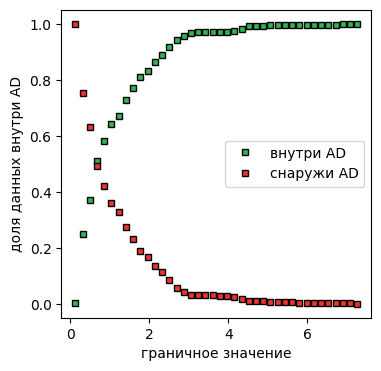

In [53]:
vis_cutoff_fraction(name="MVE", ylims=(0, 6))

C:\Users\1\AppData\Local\Temp\ipykernel_143836\3312523700.py:17: RuntimeWarning: Mean of empty slice.
  outside_mae += [np.absolute(error[~mask]).mean()]


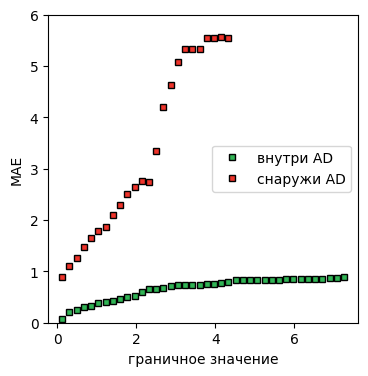

In [54]:
vis_cutoff_MAE(name="MVE", ylims=(0, 6))